In [1]:
import os, sys
from tqdm import trange, tqdm
from IPython.utils import io
from IPython.display import clear_output
import itertools

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset

source = "../source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show
import data_analysis.visualization.publication as publication
import simulate
import two_points

import models as models
from models import MLP, CNN, ResNet

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

traj_path = "plots/2 points/comparisons/"

publication.set_color_mixed(1)

GPU available


In [2]:
## Load settings
setting = "dropout"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)
    .loc[setting]
    .to_numpy()
)
model_type = getattr(models, model_type)
if nonlinearity == "discontinuous":
    nonlinearity = simulate.Discontinuous.apply
elif nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)


threshold = 1e-3
n_epochs_plot = 20000
hidden_layer = 5
L = 10

In [3]:
## Fit effective learning rates
eta_h_opts, eta_y_opts = [], []
G_hs, G_ys = [], []
for _ in range(10):
    data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

    model = model_type(
        encoding=encoding,
        input_size=1,
        output_size=1,
        hidden_dim=P,
        n_hid_layers=L,
        device=device,
        init_std=gain,
        non_linearity=nonlinearity,
    )

    # Compute G
    input_1 = data[0][0]
    input_2 = data[0][1]
    hid_1 = model(input_1)[1][hidden_layer]
    hid_2 = model(input_2)[1][hidden_layer]
    pred_1 = model(input_1)[0]
    pred_2 = model(input_2)[0]
    input_1, input_2, hid_1, hid_2, pred_1, pred_2 = [
        a.detach().numpy() for a in (input_1, input_2, hid_1, hid_2, pred_1, pred_2)
    ]
    G_h = np.linalg.norm(hid_2 - hid_1) ** 2 / np.linalg.norm(input_2 - input_1) ** 2
    G_y = np.linalg.norm(pred_2 - pred_1) ** 2 / np.linalg.norm(hid_2 - hid_1) ** 2
    G_hs.append(G_h)
    G_ys.append(G_y)
    print(f"G_h: {G_h}, G_y: {G_y}")

    criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    compiler = Compiler(model, criterion, optimizer)
    compiler.trackers = {
        "loss": ScalarTracker(lambda: compiler.validation([data])),
        "hidden": ActivationTracker(
            model, lambda inputs: model(inputs)[1][hidden_layer], datasets=[data]
        ),
        "output": ActivationTracker(
            model, lambda inputs: model(inputs)[0], datasets=[data]
        ),
    }

    h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

    compiler.training_run([data], [data], n_epochs=n_epochs, batch_size=100)

    if compiler.trackers["loss"].get_entry(-1)[0][0] > 1e-2:
        continue

    data_hid = compiler.trackers["hidden"].get_trace().copy()
    data_output = compiler.trackers["output"].get_trace().copy()
    h_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    h_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    y_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
    ]
    y_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
    ]
    epochs = np.arange(0, len(h_A))
    y_true_A, y_true_B = data[0][1].numpy(), data[1][1].numpy()
    dy2 = np.sum((y_true_B - y_true_A) ** 2)
    h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
    y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
    w = np.array(
        [
            y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
            for epoch in epochs
        ]
    )

    eta_h_opt, eta_y_opt = simulate.optimize_eta(h2, y2, w, dx2, dy2)
    eta_h_opts.append(eta_h_opt)
    eta_y_opts.append(eta_y_opt)
    print(f"eta_h: {eta_h_opt}, eta_y: {eta_y_opt}")

eta_h, eta_y = np.mean(eta_h_opts), np.mean(eta_y_opts)
G_h, G_y = np.mean(G_hs), np.mean(G_ys)

print(f"eta_h, eta_y, G_h, G_y = {eta_h}, {eta_y}, {G_h}, {G_y}")

In [4]:
# if setting == "default":
#     eta_h, eta_y = 0.0020877677068522342, 0.10208116909174215
# if setting == "elu":
#     eta_h, eta_y = 0.005803672402515137, 0.005655853213481479
# if setting == "gain_1.3":
#     eta_h, eta_y, G = 0.0018872979697360493, 0.019601273667067383, 5.409e-05
# if setting == "skip":
#     eta_h, eta_y = 0.01792881864645138, 0.0037541483387444354
# if setting == "tanh":
#     eta_h, eta_y = 0.005330850767562925, 0.004559356995640654
# if setting == "linear":
#     eta_h, eta_y = 0.006383913350493798, 0.005209085364099827
# if setting == "narrow":
#     eta_h, eta_y = 0.009019062223673728, 0.11573112446814811
# if setting == "shallow":
#     eta_h, eta_y = 0.009311294325305463, 0.015446764974931849
# if setting == "relu":
#     eta_h, eta_y = 0.0013260572599296402, 0.06614670042709664
# if setting == "cnn":
#     eta_h, eta_y = 0.1429049664638375, 0.024994515229592434

# # eta_h, eta_y = 0.009408065260520659, 0.07242601567405892  # gain_0.9 10 layers

In [3]:
# if setting == "default":
    eta_h, eta_y, G_h, G_y = (
        0.005145757394776129,
        0.032746069540209186,
        0.006580438110113726,
        0.00010444939881227756,
    )
# if setting == "elu":
# if setting == "gain_1.3":
# if setting == "skip":
# if setting == "tanh":
# if setting == "linear":
# if setting == "narrow":
# if setting == "shallow":
# if setting == "relu":
# if setting == "cnn":

TypeError: pub_show() got an unexpected keyword argument 'colors'

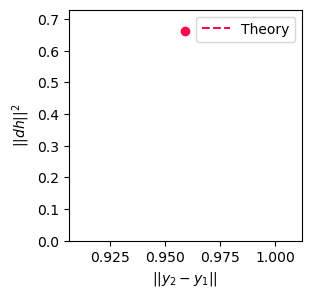

In [6]:
dx2 = 1

h0s, y0s, w0s, hs, ys, ws = [], [], [], [], [], []
dy2s = []

N = 50
m = 1

for dy in np.linspace(0, 1, N):
    dy2 = dy**2
    variables = []
    for _ in range(m):
        ## Generate data
        data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

        ## Instantiate model
        model = model_type(
            encoding=encoding,
            input_size=1,
            output_size=1,
            hidden_dim=P,
            n_hid_layers=L,
            device=device,
            init_std=gain,
            non_linearity=nonlinearity,
        )

        criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr / 3)
        compiler = Compiler(model, criterion, optimizer)
        compiler.trackers = {"loss": ScalarTracker(lambda: compiler.validation([data]))}

        h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

        ## Training run
        compiler.training_run(
            [data], [], n_epochs=n_epochs_plot, batch_size=100, conv_thresh=threshold
        )

        if compiler.trackers["loss"].get_entry(-1)[0][0] > threshold:
            break

        h, y, w = two_points.get_h_y_w(data, model, hidden_layer)

        variables.append([h0, y0, w0, h, y, w])

    if len(variables) > 0:
        variables = np.mean(np.array(variables), axis=0)
        for i, array in enumerate((h0s, y0s, w0s, hs, ys, ws)):
            array.append(variables[i])
        dy2s.append(dy2)

        clear_output(wait=True)

        fig = plt.figure(figsize=(3, 3))
        plt.scatter(np.sqrt(dy2s), hs)
        plt.xlabel("$||y_2-y_1||$")
        plt.ylabel("$||dh||^2$")
        plt.ylim(0, 1.1 * max(hs))
        # plt.plot(
        #     np.sqrt(dy2s),
        #     np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2),
        #     linestyle="--",
        #     label="Theory",
        # )
        A_low = np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2)
        A_high = (G_h - G_y * eta_h / eta_y) * dx2
        plt.plot(
            np.sqrt(dy2s),
            0.5 * A_high + np.sqrt(0.25 * A_high**2 + A_low**2),
            linestyle="--",
            label="Theory",
        )
        plt.legend()
        pub_show()

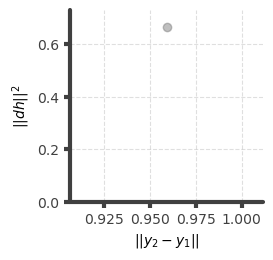

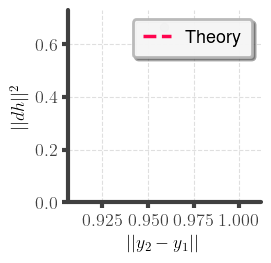

In [7]:
def plot_y():
    A_low = np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2)
    A_high = (G_h - G_y * eta_h / eta_y) * dx2
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(np.sqrt(dy2s), hs)
    plt.xlabel("$||y_2-y_1||$")
    plt.ylabel("$||dh||^2$")
    plt.ylim(0, 1.1 * max(hs))
    # plt.plot(
    #     np.sqrt(dy2s),
    #     A_low,
    #     linestyle="--",
    #     label="Theory",
    # )

    plt.plot(
        np.sqrt(dy2s),
        0.5 * A_high + np.sqrt(0.25 * A_high**2 + A_low**2),
        linestyle="--",
        label="Theory",
    )


plot_y()
pub_show(
    save_path=traj_path + "dh_vs_y_" + setting + "_no_legend" + ".png",
)
plot_y()
plt.legend()
pub_show(save_path=traj_path + "dh_vs_y_" + setting + ".png")

In [5]:
dy2 = 0.5

h0s, y0s, w0s, hs, ys, ws = [], [], [], [], [], []
dx2s = []

N = 50
m = 1

for dx in np.linspace(0.2, 1, N):
    dx2 = dx**2
    variables = []
    for _ in range(m):
        ## Generate data
        data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

        ## Instantiate model
        model = model_type(
            encoding=encoding,
            input_size=1,
            output_size=1,
            hidden_dim=P,
            n_hid_layers=L,
            device=device,
            init_std=gain,
            non_linearity=nonlinearity,
        )

        criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr / 3)
        compiler = Compiler(model, criterion, optimizer)
        compiler.trackers = {"loss": ScalarTracker(lambda: compiler.validation([data]))}

        h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

        ## Training run
        compiler.training_run(
            [data], [], n_epochs=n_epochs_plot, batch_size=100, conv_thresh=threshold
        )

        if compiler.trackers["loss"].get_entry(-1)[0][0] > 1e-2:
            break

        h, y, w = two_points.get_h_y_w(data, model, hidden_layer)

        variables.append([h0, y0, w0, h, y, w])

    if len(variables) > 0:
        variables = np.mean(np.array(variables), axis=0)
        for i, array in enumerate((h0s, y0s, w0s, hs, ys, ws)):
            array.append(variables[i])
        dx2s.append(dx2)

        clear_output(wait=True)

        fig = plt.figure(figsize=(2.5, 2.5))
        plt.scatter(np.sqrt(dx2s), hs)
        plt.xlabel("$||x_2-x_1||$")
        plt.ylabel("$||dh||^2$")
        plt.ylim(0, 1.1 * max(hs))
        # plt.plot(
        #     np.sqrt(dx2s),
        #     np.sqrt(eta_h / eta_y) * np.sqrt(dx2s) * np.sqrt(dy2),
        #     linestyle="--",
        #     label="Theory",
        # )
        A_low = np.sqrt(eta_h / eta_y) * np.sqrt(dy2) * np.sqrt(dx2s)
        A_high = (G_h - G_y * eta_h / eta_y) * dx2
        plt.plot(
            np.sqrt(dx2s),
            0.5 * A_high + np.sqrt(0.25 * A_high**2 + A_low**2),
            linestyle="--",
            label="Theory",
        )
        plt.legend()
        pub_show()

Training:  28%|██▊       | 5626/20000 [01:09<02:34, 93.12steps/s, train_loss=0.05269, val_loss=0.05866] 

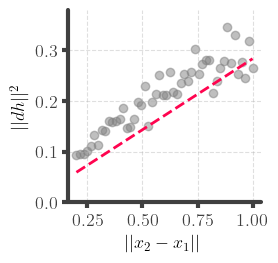

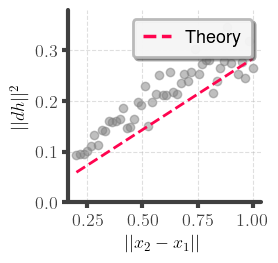

In [ ]:
def plot_x():
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(np.sqrt(dx2s), hs)
    plt.xlabel("$||x_2-x_1||$")
    plt.ylabel("$||dh||^2$")
    plt.ylim(0, 1.1 * max(hs))
    A_low = np.sqrt(eta_h / eta_y) * np.sqrt(dy2) * np.sqrt(dx2s)
    A_high = (G_h - G_y * eta_h / eta_y) * dx2
    plt.plot(
        np.sqrt(dx2s),
        0.5 * A_high + np.sqrt(0.25 * A_high**2 + A_low**2),
        linestyle="--",
        label="Theory",
    )


plot_x()
pub_show(
    save_path=traj_path + "dh_vs_x_" + setting + "_no_legend" + ".png",
)
plot_x()
plt.legend()
pub_show(save_path=traj_path + "dh_vs_x_" + setting + ".png")